In [2]:
#@title Imports and load google drive, navigate to BPD folder
import pandas as pd
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import scipy
# import hddm
import seaborn as sns
import pymc as pm
import arviz as az

# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import multiprocessing as mp



In [3]:
rng = np.random.default_rng(12345)


In [4]:
def generate_data(rng, alpha_l, alpha_g, beta, n=100, p_r=None, trials=None):
    if p_r is None:
        p_r = [0.8, 0.2, 0.7, 0.3, 0.6, 0.4]
    actions = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, 6))

    # Initialize Q table
    Q = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    for i in range(n):
        # Apply the Softmax transformation
        temp_Q = np.array([Q[trials[i][0]], Q[trials[i][0]]])
        exp_Q = np.exp(temp_Q*beta)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = rng.choice([trials[i][0], trials[i][1]], p=prob_a)
        r = rng.random() < p_r[a]

        # Update Q table
        if r < Q[a]:
            alpha = alpha_l
        else:
            alpha = alpha_g
        Q[a] = Q[a] + alpha * (r - Q[a])
        
        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs

In [5]:
data = pd.read_csv('new_d.csv').drop('Unnamed: 0', axis = 1)
data = data.sort_values(['ID', 'Session', 'Block'], ascending=[True, True, True]).reset_index().drop('index', axis = 1)
data['optimal response taken'] = data['StimulusPresentation1.RESP'] == data['StimulusPresentation1.CRESP']
procedure = 'Trainb'
ID = 1006
trials_presented = np.array([np.array([int(i), int(j)]) for i, j in data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'TrialType'].str.replace('A', '0').str.replace('B', '1').str.replace('C', '2').str.replace('D', '3').str.replace('E', '4').str.replace('F', '5').values])


In [31]:
true_alpha_l = 0.7
true_alpha_g = 0.5
true_beta = 5
n = len(trials_presented)
actions, rewards, Qs = generate_data(rng, true_alpha_l, true_alpha_g, true_beta, n, trials=trials_presented)

In [32]:
def update_Q(action, reward, Qs, alpha_l, alpha_g):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
    # pred_error = reward - Qs[action]

    if pt.gt(reward, Qs[action]): #If reward greater than Qs[action]
        alpha = alpha_g
    else:
        alpha = alpha_l


    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

def extract_action_Q(trials, Qs, extracted_Qs):
    extracted_Qs = pt.set_subtensor(extracted_Qs[0], Qs[trials[0]])
    extracted_Qs = pt.set_subtensor(extracted_Qs[1], Qs[trials[1]])
    return extracted_Qs

def pytensor_llik_td(alpha_l, alpha_g, beta, actions, rewards, trials):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    trials = pt.as_tensor_variable(trials, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((6,), dtype="float64")

    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha_l, alpha_g]
    )
    extracted_Qs = pt.ones((trials.shape.eval()[0],2), dtype = "float64")
    # print(trials.shape.eval())
    # print(extracted_Qs.shape.eval())

    extracted_Qs, updates = pytensor.scan(
        fn=extract_action_Q, sequences=[trials, Qs], outputs_info=[extracted_Qs]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)
    extracted_Qs = extracted_Qs[:-1] * beta
    logp_actions = extracted_Qs - pt.logsumexp(extracted_Qs, axis=1, keepdims=True)

    # Calculate the log likelihood of the observed actions
    # print(logp_actions[:, actions].eval())

    logp_actions = logp_actions[pt.arange(actions.shape[0] - 1), actions[1:]]
    # print(pt.sum([logp_actions[trials[0]], logp_actions[trials][1]]))
    return pt.sum([logp_actions[trials[0]], logp_actions[trials][1]])  # PyMC expects the standard log-likelihood


def right_action_probs(alpha_l, alpha_g, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((6,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha_l, alpha_g]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)
    
    # Return the probabilities for the right action, in the original scale
    return pt.exp(logp_actions[:, 1])

In [33]:
with pm.Model() as m:
    alpha_l = pm.Beta(name="alpha_l", alpha=1, beta=1)
    alpha_g = pm.Beta(name="alpha_g", alpha=1, beta=1)
    # alpha = pm.Beta(name="alpha_l", alpha=1, beta=1, shape=(2,))

    beta = pm.HalfNormal(name="beta", sigma=10)
    like = pm.Potential(name="like", var=pytensor_llik_td(alpha_l, alpha_g, beta, actions, rewards, trials_presented))

    tr = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_l, alpha_g, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 700 seconds.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'alpha_l'}>,
       <Axes: title={'center': 'alpha_g'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

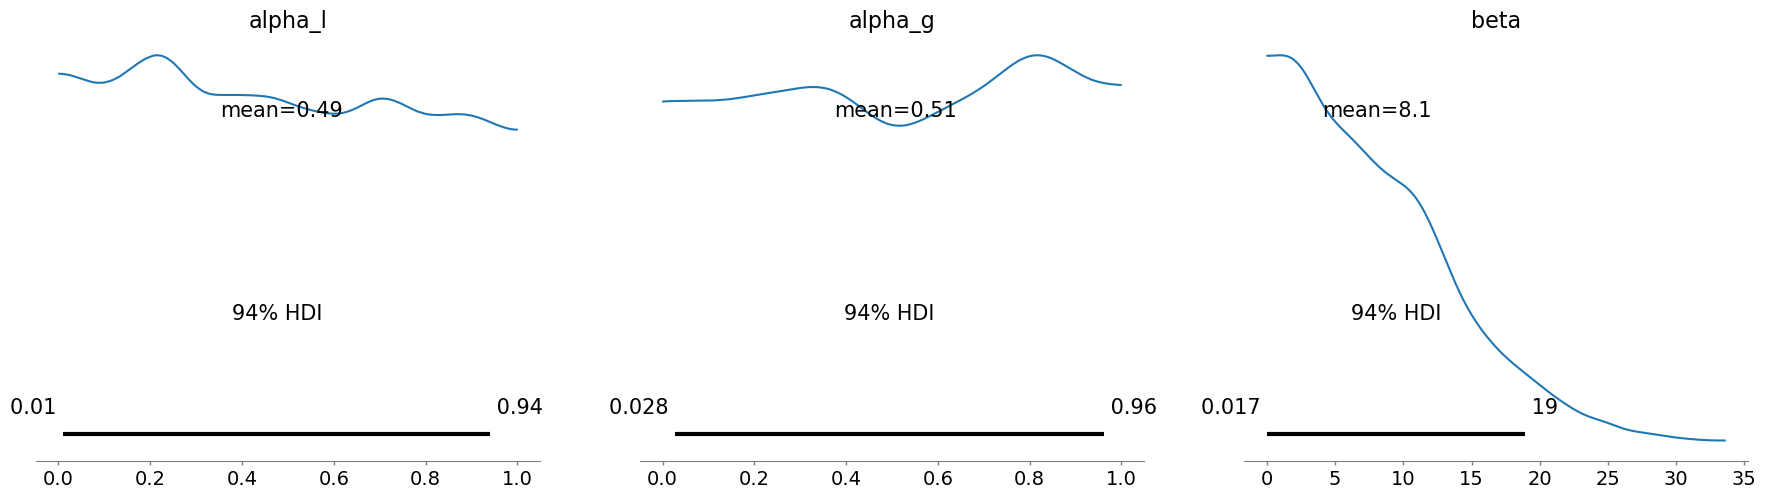

In [34]:
az.plot_posterior(tr)   

In [77]:
with pm.Model() as m_alt:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    # alpha_g = pm.Beta(name="alpha_g", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    action_probs = right_action_probs(alpha, beta, optimal_actions, rewards)
    like = pm.Bernoulli(name="like", p=action_probs, observed=optimal_actions[1:])

    tr_alt = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_l, alpha_g, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 269 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'alpha_l'}>,
       <Axes: title={'center': 'alpha_g'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

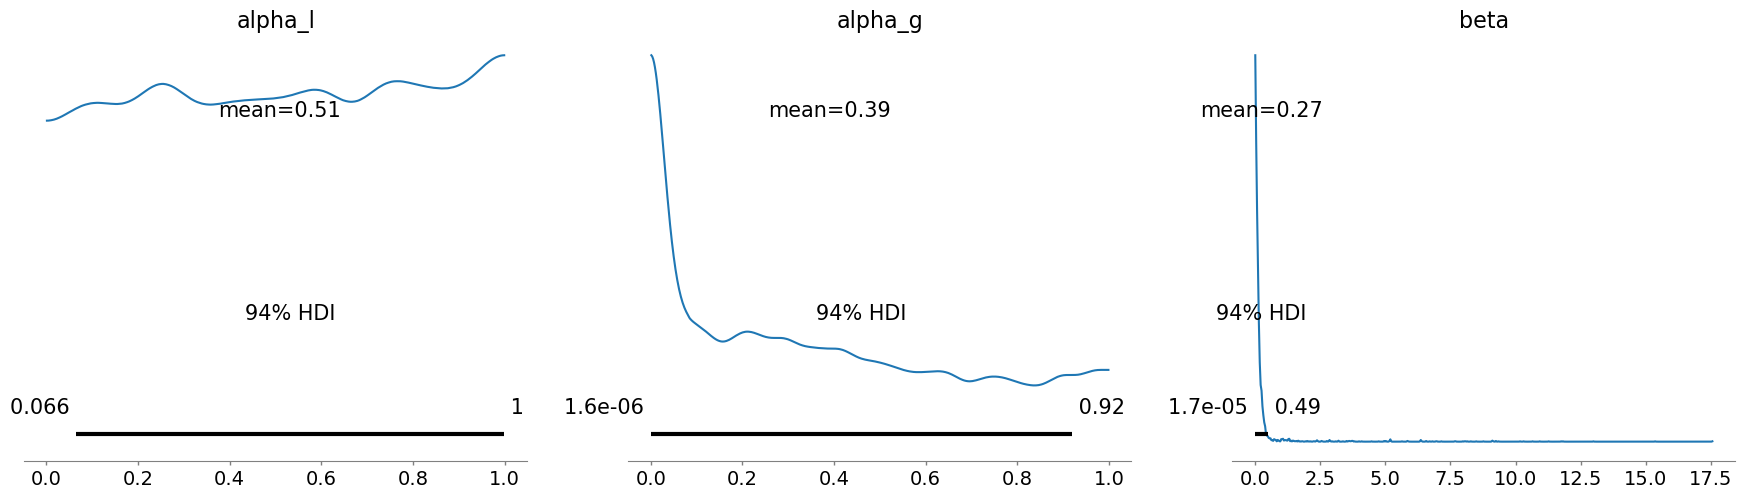

In [78]:
az.plot_posterior(tr_alt)

In [86]:
def generate_data(rng, alpha, beta, n=100, p_r=None, trials=None):
    if p_r is None:
        p_r = [0.8, 0.2, 0.7, 0.3, 0.6, 0.4]
    actions = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, 6))

    # Initialize Q table
    Q = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    for i in range(n):
        # Apply the Softmax transformation
        temp_Q = np.array([Q[trials[i][0]], Q[trials[i][0]]])
        exp_Q = np.exp(temp_Q*beta)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = rng.choice([trials[i][0], trials[i][1]], p=prob_a)
        r = rng.random() < p_r[a]

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])
        
        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs

# true_alpha_l = 0.2
true_alpha = 0.1
true_beta = 5
n = len(trials_presented)
actions, rewards, Qs = generate_data(rng, true_alpha, true_beta, n, trials=trials_presented)
optimal_actions = (actions%2 == 0).astype(int)

def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

def right_action_probs(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

    # Return the probabilities for the right action, in the original scale
    return pt.exp(logp_actions[:, 1])

In [90]:
with pm.Model() as m_alt:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)
    theta = pm.DiscreteUniform(name='theta', lower = 0, upper = 1)
    rewards = pm.Bernoulli(name='rewards', p=theta, observed = rewards)
    action_probs = right_action_probs(alpha, beta, optimal_actions, rewards)
    like = pm.Bernoulli(name="like", p=action_probs, observed=optimal_actions[1:])

    tr_alt = pm.sample(random_seed=rng)

IndexError: too many indices for array

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

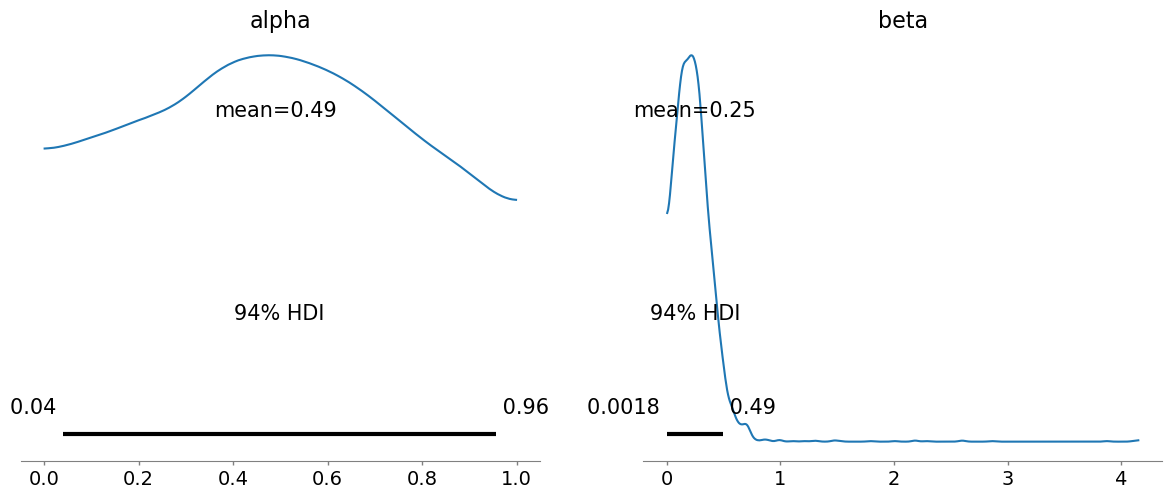

In [88]:
az.plot_posterior(tr_alt)

# From the pymc tutorial

In [16]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy

from matplotlib.lines import Line2D
seed = sum(map(ord, "RL_PyMC"))
rng = np.random.default_rng(seed)
az.style.use("arviz-darkgrid")

def generate_data(rng, alpha_l, alpha_g, beta, n=100, p_r=None):
    if p_r is None:
        p_r = [0.4, 0.6]
    actions = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([0.5, 0.5])
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta * Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = rng.choice([0, 1], p=prob_a)
        r = rng.random() < p_r[a]

        # Update Q table
        if r > Q[a]:
            alpha = alpha_l
        else:
            alpha = alpha_g
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs
true_alpha_l = 0.8
true_alpha_g = 0.5
true_beta = 5
n = 300
actions, rewards, Qs = generate_data(rng, true_alpha_l, true_alpha_g, true_beta, n)

In [17]:
def update_Q(action, reward, Qs, alpha_l, alpha_g):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
    if pt.gt(reward, Qs[action]): #If reward greater than Qs[action]
        alpha = alpha_g
    else:
        alpha = alpha_l

    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

# Transform the variables into appropriate PyTensor objects
def pytensor_llik_td(alpha_l, alpha_g, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha_l, alpha_g]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

    # Calculate the log likelihood of the observed actions
    logp_actions = logp_actions[pt.arange(actions.shape[0] - 1), actions[1:]]
    return pt.sum(logp_actions)  # PyMC expects the standard log-likelihood
with pm.Model() as m:
    alpha_l = pm.Beta(name="alpha_l", alpha=1, beta=1)
    alpha_g = pm.Beta(name="alpha_g", alpha=1, beta=1)

    beta = pm.HalfNormal(name="beta", sigma=10)

    like = pm.Potential(name="like", var=pytensor_llik_td(alpha_l, alpha_g, beta, actions, rewards))

    tr = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_l, alpha_g, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.


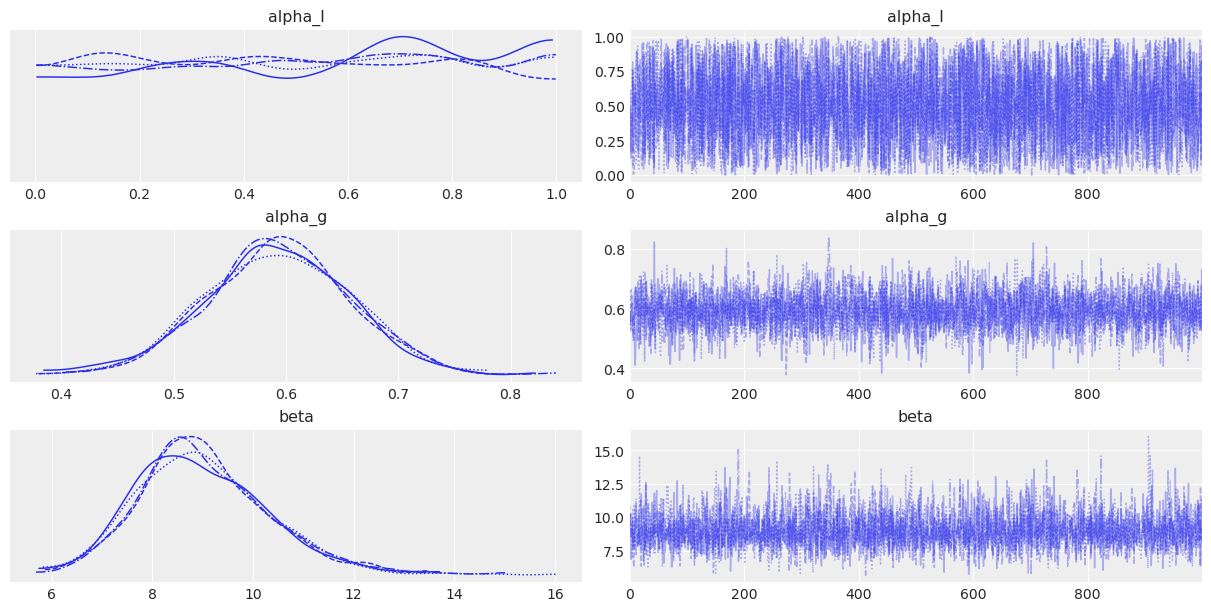

In [18]:
az.plot_trace(data=tr);


# From Bard

In [31]:
import pymc as pm
import numpy as np

# Define the number of arms
arms = 2

# Define the rewards for each arm.
rewards = [10, 5]

# Define the choice data.
choices = np.array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1])

# Convert the rewards array to a NumPy array.
rewards = np.array(rewards)

# Initialize the learning rate parameter.
learning_rate = 0.5

# Define the exploration parameter.
exploration = 1

# Define the prior rewards.
prior_rewards = [10, 5]

# Convert the prior rewards list to a NumPy array.
prior_rewards = np.array(prior_rewards)

# Create the PyMC model.
model = pm.Model((Q, learning_rate, exploration, prior_learning_rate, prior_rewards))

# Sample from the model.
posterior = pm.sample(10000, tune=1000)

# Recover the parameters.
learning_rate_estimate = posterior['learning_rate'].mean()
exploration_estimate = posterior['exploration'].mean()

# Plot the results.
plt.plot(posterior['Q'].mean(axis=0))
plt.xlabel('Arm')
plt.ylabel('Expected Reward')
plt.title('Bayesian Reinforcement Learning')
plt.show()


AttributeError: 'tuple' object has no attribute 'endswith'